# Assignment 3

## *Generating useful features for further analysis on Amazon reviews*
<h2>Introduction</h2>
<p><strong>Business Context.</strong> You are a business consultant with new clients that are interested in analyzing reviews of their products on Amazon (as opposed to Yelp). They want to answer business questions like: "What are the most important factors driving negative reviews?", "Have there been any large changes to customer satisfaction/reviews over time?", etc.</p>
<p><strong>Business Problem.</strong> Your main task is to <strong>explore the given data and use the results of your investigation to engineer relevant features that could facilitate subsequent analysis and model-building</strong>.</p>
<p><strong>Analytical Context.</strong> The dataset provided is a large body of reviews related to movies and television left on Amazon between 1996 and 2014. When exploring our dataset, we will quickly encounter a familiar problem we discussed in the previous case: the word "good" is one of the most important words in both positive <em>and</em> negative reviews. Thus, we must develop methods to put "good" in the appropriate context.</p>

<h2>Loading the data</h2>
<p>We use a dataset of around 37,000 video reviews from Amazon Instant Video and 1,700,000 movie and TV reviews, all obtained from the website: http://jmcauley.ucsd.edu/data/amazon/. Note that there are much larger datasets available at the same site. We can expect better and more consistent results on larger datasets (such as book reviews). Note that these datasets are compressed (gzipped), and they are in <a href="https://en.wikipedia.org/wiki/JSON">JSON</a> format, with each line representing a review and each line being its own JSON object.</p>
<p>We begin by loading the dataset below:</p>

In [27]:
%matplotlib inline

In [28]:
%%time
import gzip
import json
import string
import re

import nltk # imports the natural language toolkit
import pandas as pd
import plotly

from collections import Counter
from datetime import datetime
from sklearn.feature_extraction.text import CountVectorizer

nltk.download('punkt')


# we can tell pandas that our file is in gzip format and it will handle the decompression for us
# we also use `lines=True` to indicate that each line of the file is its own JSON object
instant_video = pd.read_json("reviews_Amazon_Instant_Video_5.json.gz", lines=True, compression='gzip')


# ----------
# The Movies and TV file is very big. If you have problems loading it, you can load only the first 
# 100,000 reviews by using 'chunksize' (uncomment the line with 'chunksize' and comment out the line 
# after that which loads the entire file into `movies_tv`). All of the analysis can be 
# done in the same way using only the subset of reviews but some of the results might be different from the examples.
# ----------
# movies_tv = next(pd.read_json("reviews_Movies_and_TV_5.json.gz", lines=True, compression='gzip', chunksize=10000))
movies_tv =movies_tv = next(pd.read_json("reviews_Movies_and_TV_5.json.gz", lines=True, compression='gzip', chunksize=10000))

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\caoth\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Wall time: 853 ms


<h2>Examining the data</h2>
<p>We take a look at the first 5 rows of each dataset to see what attributes are available. These are</p>
<ul>
<li><strong>reviewerID:</strong> A unique ID to identify the author of the review.</li>
<li><strong>asin:</strong> The <a href="https://www.amazon.com/gp/seller/asin-upc-isbn-info.html">"Amazon Standard Identification Number"</a> which provides more information about the exact product and version.</li>
<li><strong>reviewerName:</strong> The username chosen by the reviewer.</li>
<li><strong>helpful:</strong> A record of how many users indicated that the review was helpful/not helpful.</li>
<li><strong>reviewText:</strong> The full text of the review.</li>
<li><strong>overall:</strong> The overall rating (1-5) left by the reviewer.</li>
<li><strong>summary:</strong> A short version of the review, used as the title.</li>
<li><strong>unixReviewTime:</strong> The date that the review was created, in <a href="https://en.wikipedia.org/wiki/Unix_time">Unix Epoch</a> format.</li>
<li><strong>reviewTime:</strong> A human readable date giving the day, month, and year.
</font></li>
</ul>

In [29]:
print(len(instant_video))
print(instant_video.head(5))

37126
       reviewerID        asin                    reviewerName helpful  \
0  A11N155CW1UV02  B000H00VBQ                        AdrianaM  [0, 0]   
1  A3BC8O2KCL29V2  B000H00VBQ                         Carol T  [0, 0]   
2   A60D5HQFOTSOM  B000H00VBQ  Daniel Cooper "dancoopermedia"  [0, 1]   
3  A1RJPIGRSNX4PW  B000H00VBQ                  J. Kaplan "JJ"  [0, 0]   
4  A16XRPF40679KG  B000H00VBQ                   Michael Dobey  [1, 1]   

                                          reviewText  overall  \
0  I had big expectations because I love English ...        2   
1  I highly recommend this series. It is a must f...        5   
2  This one is a real snoozer. Don't believe anyt...        1   
3  Mysteries are interesting.  The tension betwee...        4   
4  This show always is excellent, as far as briti...        5   

                          summary  unixReviewTime   reviewTime  
0      A little bit boring for me      1399075200   05 3, 2014  
1           Excellent Grown Up TV 

In [30]:
print(len(movies_tv))
print(movies_tv.head(5))

10000
       reviewerID        asin                         reviewerName helpful  \
0   ADZPIG9QOCDG5  0005019281  Alice L. Larson "alice-loves-books"  [0, 0]   
1  A35947ZP82G7JH  0005019281                        Amarah Strack  [0, 0]   
2  A3UORV8A9D5L2E  0005019281                      Amazon Customer  [0, 0]   
3  A1VKW06X1O2X7V  0005019281           Amazon Customer "Softmill"  [0, 0]   
4  A3R27T4HADWFFJ  0005019281                                 BABE  [0, 0]   

                                          reviewText  overall  \
0  This is a charming version of the classic Dick...        4   
1  It was good but not as emotionally moving as t...        3   
2  Don't get me wrong, Winkler is a wonderful cha...        3   
3  Henry Winkler is very good in this twist on th...        5   
4  This is one of the best Scrooge movies out.  H...        4   

                                        summary  unixReviewTime   reviewTime  
0                     good version of a classic      12

<p>We notice that <code>movies_tv</code> is extremely long with nearly 2 million reviews, and several columns seem uninteresting or hard to work with (e.g. <code>reviewerID</code>, <code>asin</code>, <code>reviewername</code>, <code>reviewtime</code>). We drop some information to make some of our later analysis more efficient. We also add a datetime column with Python datetime objects to more easily summarize the data:</p>

In [31]:
%%time
movies_tv['datetime'] = pd.to_datetime(movies_tv['reviewTime'], format="%m %d, %Y")
instant_video['datetime'] = pd.to_datetime(instant_video['reviewTime'], format="%m %d, %Y")

Wall time: 105 ms


In [32]:
movies_tv = movies_tv.drop(columns = ['reviewerID', 'asin', 'reviewerName', 'reviewTime'])
instant_video = instant_video.drop(columns = ['reviewerID', 'asin', 'reviewerName', 'reviewTime'])

movies_tv.head(5)

,helpful,reviewText,overall,summary,unixReviewTime,datetime
0,"[0, 0]",This is a charming version of the classic Dick...,4,good version of a classic,1203984000,2008-02-26
1,"[0, 0]",It was good but not as emotionally moving as t...,3,Good but not as moving,1388361600,2013-12-30
2,"[0, 0]","Don't get me wrong, Winkler is a wonderful cha...",3,Winkler's Performance was ok at best!,1388361600,2013-12-30
3,"[0, 0]",Henry Winkler is very good in this twist on th...,5,It's an enjoyable twist on the classic story,1202860800,2008-02-13
4,"[0, 0]",This is one of the best Scrooge movies out. H...,4,Best Scrooge yet,1387670400,2013-12-22


<h3>Exercise 1:</h3>
<h4>1.1</h4>
<p>Plot histograms of all numeric quantities. Do you notice anything interesting about them?</p>

**Answer.**

# The 5 star has the highest numbers (20000),but number of 1 start and 2 start are likely equal to each other.

-------

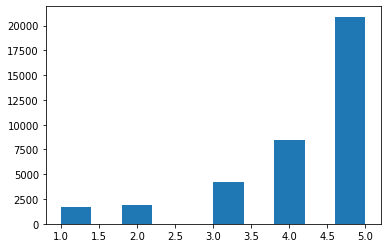

In [33]:
x=instant_video["overall"]
import matplotlib.pyplot as plt
plt.hist(x)
plt.show()

<h4>1.2</h4>
<p>How do average ratings change over time? Plot the average rating for each year and note any trends.</p>

**Answer.**

### The average rating of overtime does not change much.It moves around rating 4.

-------

## years in data

In [34]:
movies_tv["datetime"].dt.year.unique()

array([2008, 2013, 2009, 2014, 2007, 2012, 2001, 2003, 2010, 2011, 2002,
       2005, 2006, 2000, 2004, 1998, 1999], dtype=int64)

In [35]:
movies_tv.groupby("datetime")
dd=movies_tv.groupby(movies_tv.datetime.dt.year)

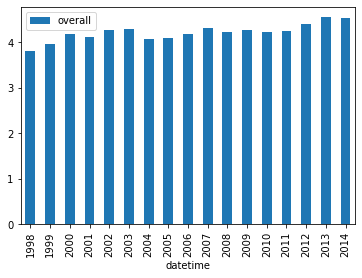

In [10]:
xa=dd.mean()
xn=xa.drop(columns='unixReviewTime')
xn.plot(kind="bar")
plt.show()

<h4>1.3</h4>
<p>Look at the average length of the review by year. Do you notice any trends?</p>

**Answer.**

The average review is tending to increase slightly from 4 to 4.2.It shows a small improvement of Amazon company.


-------

<h3>Exercise 2:</h3>
<h4>2.1</h4>
<p>Find the ten most frequently occuring non-stop words acrooss: (i) all reviews, (ii) positive reviews, (iii) negative reviews. Do the results surprise you? Why or why not?</p>

**Answer.**

## Yes, I do, there is some words like "blue ray, or passion christ" in popular positive review, even these words does not make sense to me.

-------

In [11]:
da=movies_tv.copy()

In [12]:
def get_top_n_words(corpus, n=1,k=1):
    vec = CountVectorizer(ngram_range=(k,k),stop_words = 'english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

### Overall review

movie 13464
film 10666
like 4838
great 4329
good 4238
quot 4106
just 4046
story 3686
time 3612
really 2877


<AxesSubplot:title={'center':'Top 10 words from all reviews'}, xlabel='ReviewText'>

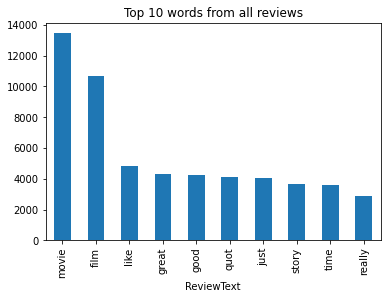

In [36]:
common_words = get_top_n_words(da['reviewText'], 10,1)
for word, freq in common_words:
    print(word, freq)
df = pd.DataFrame(common_words, columns = ['ReviewText' , 'count'])
df.groupby('ReviewText').sum()['count'].sort_values(ascending=False).plot(
    kind='bar',  title='Top 10 words from all reviews')

### split the data into 2 groups

In [37]:
podf=movies_tv[movies_tv["overall"]>3]
nedf=movies_tv[movies_tv["overall"]<3]

### Positive common words

movie 10740
film 8445
great 3871
like 3653
quot 3331
good 3311
just 3022
story 3016
time 2986
love 2470


<AxesSubplot:title={'center':'Top 10 words from all positie reviews'}, xlabel='ReviewText'>

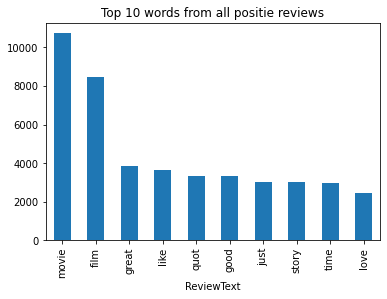

In [38]:
common_words = get_top_n_words(podf['reviewText'], 10,1)
for word, freq in common_words:
    print(word, freq)
df = pd.DataFrame(common_words, columns = ['ReviewText' , 'count'])
df.groupby('ReviewText').sum()['count'].sort_values(ascending=False).plot(
    kind='bar',  title='Top 10 words from all positie reviews')

## Negative common words

movie 1390
film 1089
like 592
just 499
jesus 469
quot 393
good 346
really 302
story 299
people 298


<AxesSubplot:title={'center':'Top 10 words from all negative reviews'}, xlabel='ReviewText'>

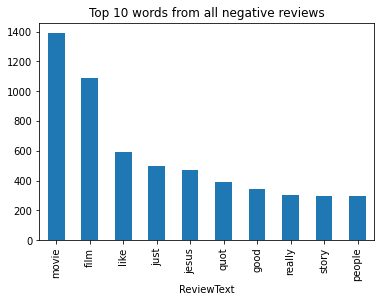

In [39]:
common_words = get_top_n_words(nedf['reviewText'], 10,1)
for word, freq in common_words:
    print(word, freq)
df = pd.DataFrame(common_words, columns = ['ReviewText' , 'count'])
df.groupby('ReviewText').sum()['count'].sort_values(ascending=False).plot(
    kind='bar',  title='Top 10 words from all negative reviews')

<h4>2.2</h4>
<p>Find words that are indicative of bad reviews. That is, words that appear often in bad reviews and <em>not</em> in good reviews. What are these words and are they surprising?</p>

**Answer.**

-------

###  'like','jesus','good','really'. Yes, they are all the good words, you think it should be supposed in the good review.

<h3>Exercise 3:</h3>
<p>Manually inspect the first 10 negative reviews containing the word "good". What do you notice? How does this suggest we ought to proceed next?</p>

**Answer.**

-------

after 'good' word, there is some contracst like 'but', 'even', or some negative world like 'damage'.

'I think to evaluate a review whether it is good or bad. We should not only base on the 'good' word, we also may look at the neighbors of words, before deciding the meaning of the review. A negative review ussually contain a lot of contradictive words (such as disagree,sadist) and bad words  (such as blood,damage), even it could contain a word 'good'.


In [257]:
for i in nedf["reviewText"][0:20]:
    if "good" in i:
        
        a=i.replace(".","\n")
        print(a,'\n \n')

The acting was good, the story was correct, but naked backsides was not necessary
  Also the Potiphers wife did not need to be so very seductive of a naked Joseph
 Not a Christian movie
  I felt that even though it was probably portrayed truthfully, Christans do not need to see so explicit a scene
  This should be rated PG 13 at least
 
 

The DVD transfer is pretty good but the scene with Yukon discovering peppermint has been cut
It seems pretty odd to sell a DVD as a restored classic only to leave out the main thing that was to be restored! 
 



<h3>Exercise 4:</h3>
<p>Go through the list of bad reviews containing the word "good" that we found in the last question. For each review, extract the following:</p>
<ol>
<li>The first word after "good"</li>
<li>The first word after "good" that is a noun or cardinal</li>
<li>The last word before "good" that is a noun or cardinal</li>
</ol>

## first word after "good"

**Answer.**

-------

In [18]:
def checkgood(tx):
    if "good" in tx:
        return True
    else:
        return False


In [19]:
gooddf=nedf[nedf["reviewText"].apply(checkgood)]


In [20]:
nltk.download('averaged_perceptron_tagger')


[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\caoth\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

# the first word after 'good'

In [21]:
def firstwordaftergood(review):
    text = nltk.word_tokenize(review)
    g=nltk.pos_tag(text)
    try:
        k=[i[0] for i in g].index("good")
        if g[k+1][1]!=",":
            return g[k+1]
        else:
            return g[k+2]
    except ValueError:
        pass
   
    


In [22]:
gooddf["reviewText"]

186     The acting was good, the story was correct, bu...
405     The DVD transfer is pretty good but the scene ...
503     ANOTHER American cultural icon from the 60's h...
576     why would mel gibson make a movie that would p...
595     Viewed: 5/14Rate: 15/14: The Passion of the Ch...
                              ...                        
9764    I was expecting this to be really good after a...
9844    If you like your films to be fast food with ex...
9857    This movie starts off interesting, with Ricci ...
9865    I can not stress how disappointed I was and ho...
9912    The animation is good, especially considering ...
Name: reviewText, Length: 229, dtype: object

In [23]:
gooddf["reviewText"].apply(firstwordaftergood)

186            (the, DT)
405            (but, CC)
503            (vs., FW)
576           (plot, NN)
595         (cinema, NN)
              ...       
9764         (after, IN)
9844      (dialogue, NN)
9857              (., .)
9865       (actress, NN)
9912    (especially, RB)
Name: reviewText, Length: 229, dtype: object

## The first word after "good" that is a noun or cardinal

In [24]:
def firstwordnounaftergood(review):
    text = nltk.word_tokenize(review)
    g=nltk.pos_tag(text)
    try:
        k=[i[0] for i in g].index("good")
        if k<len(g):
            for j in list(range(k,len(g))):
                if "NN" in g[j] or "CD" in g[j]:
                    return g[j]
                
    except ValueError:
        pass

In [25]:
gooddf["reviewText"].apply(firstwordnounaftergood)

186        (story, NN)
405        (scene, NN)
503         (evil, NN)
576         (plot, NN)
595       (cinema, NN)
             ...      
9764         (way, NN)
9844    (dialogue, NN)
9857       (adept, NN)
9865     (actress, NN)
9912        (quot, NN)
Name: reviewText, Length: 229, dtype: object

<h3>Exercise 5:</h3>
<p>We have seen that individual words are not always very informative. Look for the most informative bigrams and trigrams, in both positive and negative reviews. Show the most informative bigrams and trigrams and give a brief analysis of the n-grams you identified.</p>

**Answer.**

-------

##  the most informative in positive reveiw
great movie 377  <br />

does great job 54 <br />
highly recommend movie 51<br />
did great job 46<br />

##  the most informative in negative reviews

don know 42  <br />
ve seen 37  <br />
waste time 33  <br />
spice girls 33  <br />


waste time money 8   <br />
don waste time 7   <br />

# Positive review

## bigram -positive review

blu ray 646
sci fi 470
mel gibson 434
special effects 417
great movie 377
passion christ 351
ve seen 337
gary oldman 264
year old 256
years ago 250


<AxesSubplot:title={'center':'Top 10 words from all reviews'}, xlabel='ReviewText'>

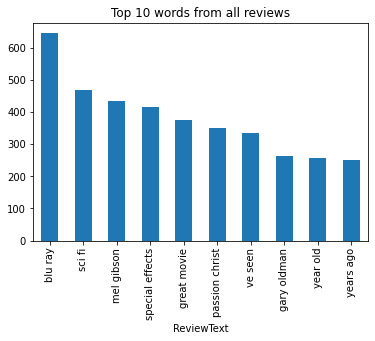

In [43]:
common_words = get_top_n_words(podf['reviewText'], 10,2)
for word, freq in common_words:
    print(word, freq)
dp = pd.DataFrame(common_words, columns = ['ReviewText' , 'count'])
dp.groupby('ReviewText').sum()['count'].sort_values(ascending=False).plot(
    kind='bar',  title='Top 10 words from all reviews')

## trigram-positive review

tommy lee jones 132
world war ii 102
close encounters kind 88
red nosed reindeer 68
12 year old 68
rudolph red nosed 66
does great job 54
highly recommend movie 51
new york city 48
did great job 46


<AxesSubplot:title={'center':'Top 10 words from all reviews'}, xlabel='ReviewText'>

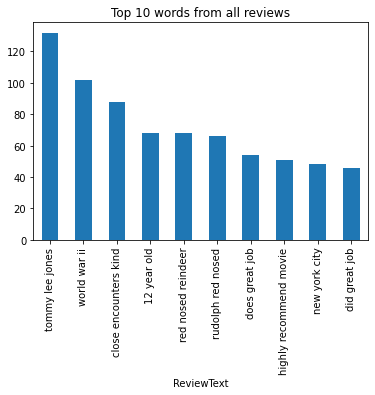

In [44]:
common_words = get_top_n_words(podf['reviewText'], 10,3)
for word, freq in common_words:
    print(word, freq)
dp = pd.DataFrame(common_words, columns = ['ReviewText' , 'count'])
dp.groupby('ReviewText').sum()['count'].sort_values(ascending=False).plot(
    kind='bar',  title='Top 10 words from all reviews')

## negative-bigrams

mel gibson 87
passion christ 65
special effects 55
jesus christ 44
jane eyre 43
don know 42
blu ray 42
ve seen 37
waste time 33
spice girls 33


<AxesSubplot:title={'center':'Top 10 words from all reviews'}, xlabel='ReviewText'>

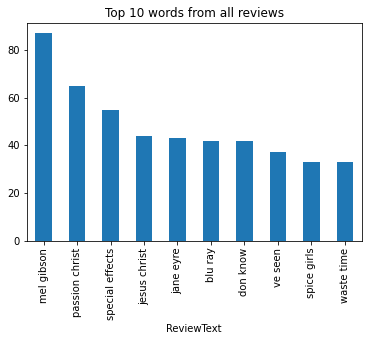

In [47]:
common_words = get_top_n_words(nedf['reviewText'], 10,2)
for word, freq in common_words:
    print(word, freq)
dn = pd.DataFrame(common_words, columns = ['ReviewText' , 'count'])
dn.groupby('ReviewText').sum()['count'].sort_values(ascending=False).plot(
    kind='bar',  title='Top 10 words from all reviews')

## negative-trigrams

blu ray player 11
gibson passion christ 9
waste time money 8
don waste time 7
12 year old 7
quot starship troopers 7
starship troopers quot 7
mel gibson passion 6
let just say 6
timothy dalton version 6


<AxesSubplot:title={'center':'Top 10 words from all reviews'}, xlabel='ReviewText'>

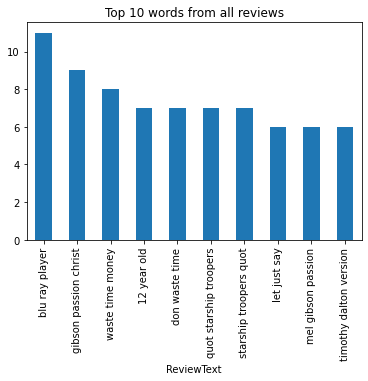

In [50]:
common_words = get_top_n_words(nedf['reviewText'], 10,3)
for word, freq in common_words:
    print(word, freq)
dn = pd.DataFrame(common_words, columns = ['ReviewText' , 'count'])
dn.groupby('ReviewText').sum()['count'].sort_values(ascending=False).plot(
    kind='bar',  title='Top 10 words from all reviews')

<h3>Exercise 6:</h3>
<p>Throughout the above search for informative words, we have seen that unigrams are not enough, but important words (such as "good") are not always next to the informative words that they describe. Devise a method to extract these informative words. Provide a brief description of how you will extract the informative words.</p>

**Answer.**

### To extract the informative words:
First, we should start with unigrams, to have the general ideas and it takes less time to run than bigram and trigram, then we will compare the popular words in good reviews and bad reviews to find the informative words.

Next, we will need to find the group of the informative words. For example, if the informative words is adjective , we need to find the noun go with this informative word, and list them out.

If the informative words is a verb, we need to find the adverbs which go with the adverb.

When we look at the group of words, we will have more clear information about the reviews.

-------

<h3>Exercise 7:</h3>
<p>Write a function(s) that transforms a sentence into a new text list by iteratively pairing each adjective in the sentence with the next noun that follows it in the sentence. For example, the text "That was a good, long movie" should return <code>["good movie", "long movie"]</code>.</p>

**Answer.**

-------

In [163]:
rew="That was a good , bad showing?"

## at sentence level

In [206]:
def adjreturn(rew):
    text = nltk.word_tokenize(rew)
    g=nltk.pos_tag(text)
    for j in list(range(0,len(g))):
        out=['']
        if 'JJ' in g[j] and j<len(g)-3:
            if 'JJ' in g[j+1] and 'NN' in g[j+2]:
                out=[g[j][0]+" "+g[j+2][0],g[j+1][0]+" "+g[j+2][0]]
                break
            elif ',' in g[j+1] and 'JJ' in g[j+2] and 'NN' in g[j+3]:
                out=[g[j][0]+" "+g[j+3][0],g[j+2][0]+" "+g[j+3][0]]
                break
            elif 'NN' in g[j+1]:
                out=[g[j][0]+" "+g[j+1][0]]
                break
    
    return out

## at paragraph level

In [236]:
def adjnoun(z):
    sentences = nltk.sent_tokenize(z)
    e=[]
    for sen in sentences:
        u=adjreturn(sen)
        e=e+u
    while '' in e:
        e.remove('')
    if ' ' in e:
        e.remove(' ')
    return e


### I only print the first ten review, it would take long time to run all.

In [241]:
result=movies_tv['reviewText'][:10].apply(adjnoun)
print(result)

0                     [charming version, good showing]
1                                                   []
2                                [wonderful character]
3                                [conventional remake]
4                                                   []
5              [favorite movie, modern day, new twist]
6    [American adaptation, main character, outstand...
7                                   [american classic]
8                                         [good job.a]
9                                [bitter man, old man]
Name: reviewText, dtype: object
